In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")
sys.path.append("../..")

import json
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from ast import literal_eval
from typing import List
from functools import reduce

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {"grid.color": ".9"})

from src.paper_analysis_hydropower import NationalAnalysisHydropower, plot_pre_post_bias_correction_validation

In [3]:
cm = 1 / 2.54

In [4]:
paths = json.load(open("../../paths.json"))

path_data = Path(paths["path_data"])
path_data_streamflow = Path(paths["path_data_streamflow"])
path_data_polygons = Path(paths["path_data_polygons"])

path_data_hydro = path_data / "hydropower"
path_swiss_maps = path_data / "maps" / "swissboundaries3d_2023-01_2056_5728/"
path_polygon_connectivity = path_data / "st2km2_PolygonConnectivity"

path_figs = Path(paths["path_figs"])

In [5]:
gdf_switzerland = gpd.read_file(path_swiss_maps / "swissBOUNDARIES3D_1_4_TLM_LANDESGEBIET.shp").to_crs("EPSG:2056")

## Load BAFU polygons
gdf_polygons = gpd.read_file(path_data_polygons / "EZG_Gewaesser.gpkg")

## Load collocated hydropower locations and BAFU polygons
df_hydropower_polygons = pd.read_json(path_data_hydro / "hydropower_polygons" / "df_hydropower_polygons.json", orient="records")
gdf_hydropower_polygons = gpd.GeoDataFrame(df_hydropower_polygons, geometry=gpd.points_from_xy(df_hydropower_polygons["_x"], df_hydropower_polygons["_y"]), crs="EPSG:2056")

## Load hydropower characteristics
df_wasta = pd.read_excel(path_data_hydro / "stats_hydropower_ch" / "wasta_2023_updated.xlsx")

## Load hydropower production (with simplified efficiency and with/without beta coefficient)
ds_hydropower_generation = xr.open_dataset(path_data_streamflow / "ds_prevah_500_hydropower_production_ror_simplified_efficiency.nc")
ds_hydropower_generation_beta = xr.open_dataset(path_data_streamflow / "ds_prevah_500_hydropower_production_ror_simplified_efficiency_with_beta.nc")
ds_hydropower_generation_merged = xr.merge([ds_hydropower_generation.rename({"gen": "hp_no_beta"}),
                                            ds_hydropower_generation_beta.rename({"gen": "hp_with_beta"})]).load()

df_hydropower_production_params = pd.read_csv(path_data_streamflow / "ds_prevah_500_hydropower_production_parameters.csv")
df_hydropower_production_params.loc[df_hydropower_production_params["Expected yearly generation"] == 0, "Expected yearly generation"] = \
    df_hydropower_production_params[df_hydropower_production_params["Expected yearly generation"] == 0].apply(lambda row: round(row["Capacity"] * 365 * 24 * 1e-6, 2), axis=1)

## Load historical Swiss electricity generation data
df_historical_data = pd.read_csv(path_data / "energy" / "ogd35_schweizerische_elektrizitaetsbilanz_monatswerte.csv")

# Analyse data (without monthly bias correction)

In [6]:
national_analysis_pre_correction = NationalAnalysisHydropower(gdf_switzerland, gdf_hydropower_polygons, df_wasta,
                                               ds_hydropower_generation_merged, 
                                               df_hydropower_production_params, 
                                               df_historical_data[["Jahr", "Monat", "Erzeugung_laufwerk_GWh", 
                                                                   "Erzeugung_speicherwerk_GWh", 
                                                                   "Verbrauch_speicherpumpen_GWh"]], 
                                               path_figs)

In [7]:
national_analysis_pre_correction.aggregate_yearly_estimated_generation(with_percentage=False)
national_analysis_pre_correction.aggregate_yearly_estimated_generation_with_operation_start(with_percentage=False)
national_analysis_pre_correction.aggregate_yearly_estimated_generation_per_hp()
national_analysis_pre_correction.aggregate_yearly_estimated_generation_per_hp(reference_period=slice("1991", "2020"))

In [8]:
national_analysis_pre_correction.aggregate_seasonal_estimated_generation(with_operation_start=False)
national_analysis_pre_correction.aggregate_seasonal_estimated_generation(with_operation_start=True)
national_analysis_pre_correction.aggregate_seasonal_estimated_generation(with_operation_start=False, per_hydropower=True)
national_analysis_pre_correction.aggregate_reference_seasonal_estimated_generation()

# Analyse data (with monthly bias correction)

In [9]:
ds_monthly_bias_correction_factors = xr.open_dataset(path_data_streamflow / "ds_prevah_500_hydropower_production_ror_simplified_efficiency_monthly_bias_correction_factors.nc").bias_correction_factor.load()

In [10]:
national_analysis = NationalAnalysisHydropower(gdf_switzerland, gdf_hydropower_polygons, df_wasta,
                                               ds_hydropower_generation_merged * ds_monthly_bias_correction_factors, 
                                               df_hydropower_production_params, 
                                               df_historical_data[["Jahr", "Monat", "Erzeugung_laufwerk_GWh", 
                                                                   "Erzeugung_speicherwerk_GWh", 
                                                                   "Verbrauch_speicherpumpen_GWh"]], 
                                               path_figs)

In [11]:
national_analysis.aggregate_yearly_estimated_generation(with_percentage=False)
national_analysis.aggregate_yearly_estimated_generation_with_operation_start(with_percentage=False)
national_analysis.aggregate_yearly_estimated_generation_per_hp()
national_analysis.aggregate_yearly_estimated_generation_per_hp(reference_period=slice("1991", "2020"))

In [12]:
national_analysis.aggregate_seasonal_estimated_generation(with_operation_start=False)
national_analysis.aggregate_seasonal_estimated_generation(with_operation_start=True)
national_analysis.aggregate_seasonal_estimated_generation(with_operation_start=False, per_hydropower=True)
national_analysis.aggregate_reference_seasonal_estimated_generation()

# Paper plots

## Fig 2

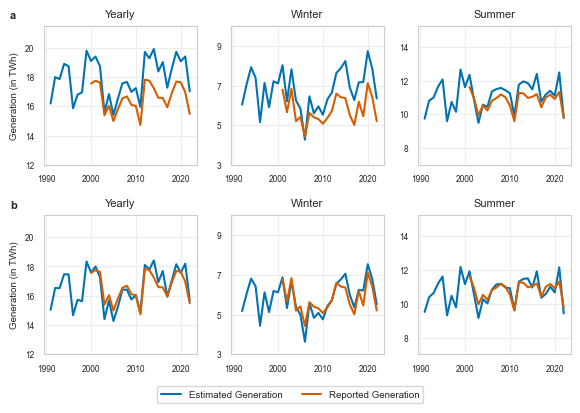

In [13]:
plot_pre_post_bias_correction_validation(
    national_analysis_pre_correction,
    national_analysis,
    with_percentage=False, 
    yearly_column_to_plot="Estimated Generation No Beta",
    winter_column_to_plot="Estimated Generation No Beta Winter",
    summer_column_to_plot="Estimated Generation No Beta Summer",
    subplots_titles=["Yearly", 
                     "Winter", 
                     "Summer"], 
    save=True, 
    output_filename="fig_2.pdf"
)

## Fig 3

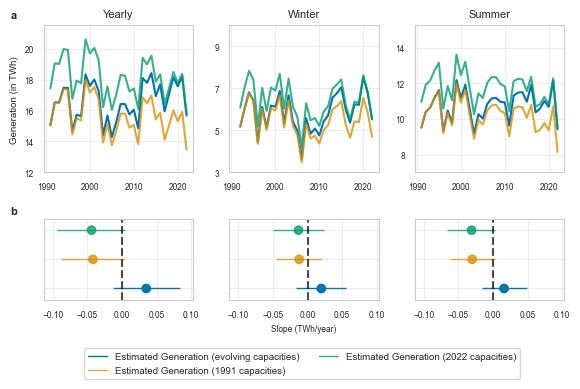

In [14]:
national_analysis.plot_trend_analysis(
        with_percentage=False, 
        yearly_column_to_plot="Estimated Generation No Beta",
        winter_column_to_plot="Estimated Generation No Beta Winter",
        summer_column_to_plot="Estimated Generation No Beta Summer",
        subplots_titles=["Yearly", "Winter", "Summer"],
        save=True,
        output_filename="fig_3.pdf",
    )

## Fig 4

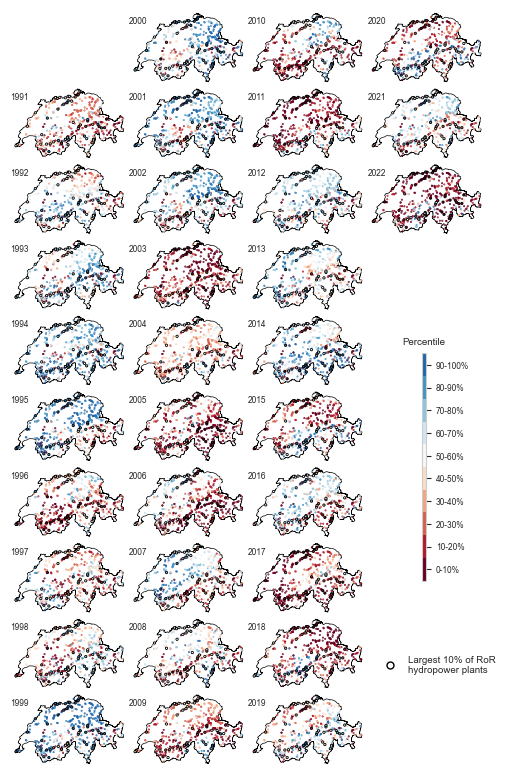

In [83]:
national_analysis.plot_quantile_maps(yearly=True, 
                                     variable_name="hp_no_beta",
                                     save=True,
                                     output_filename="fig_4.pdf"
                                    )

# Supplementary material

## Run-of-river hydropower in Switzerland

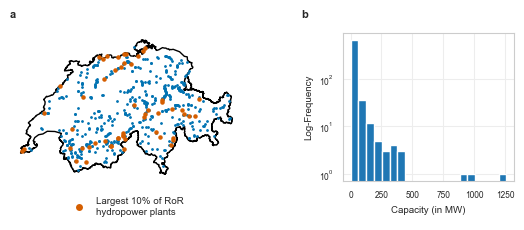

In [82]:
national_analysis.plot_ror_map_capacities_hist(save=True, output_filename="sup_fig_1.pdf")

In [80]:
national_analysis.gdf_hydropower_locations.loc[(national_analysis.gdf_hydropower_locations["WASTANumber"].isin(
            national_analysis.ds_hydropower_generation.hydropower.values
            )), "Capacity"].sum()

4891.03

In [81]:
national_analysis.gdf_hydropower_locations.loc[(national_analysis.gdf_hydropower_locations["WASTANumber"].isin(
            national_analysis.ds_hydropower_generation.hydropower.values
            )), "Capacity"].describe()

count    601.000000
mean       8.138153
std       18.714810
min        0.270000
25%        0.600000
50%        1.420000
75%        5.200000
max      157.500000
Name: Capacity, dtype: float64

In [101]:
national_analysis.gdf_hydropower_locations.loc[(national_analysis.gdf_hydropower_locations["WASTANumber"].isin(
            national_analysis.ds_hydropower_generation.hydropower.values
            )), "Capacity"].quantile(0.9)

24.0

In [102]:
national_analysis.gdf_hydropower_locations.loc[(national_analysis.gdf_hydropower_locations["WASTANumber"].isin(
            national_analysis.ds_hydropower_generation.hydropower.values
            )) & (national_analysis.gdf_hydropower_locations["Capacity"] >= 24), "Capacity"].sum()/4891.03

0.6628194879197224

## RoR hydropower generation trends

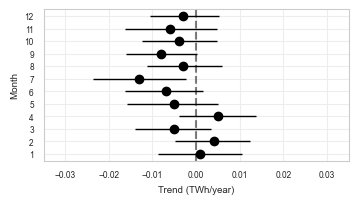

In [76]:
national_analysis.plot_trend_analysis_per_month(variable_name="hp_no_beta", save=True, output_filename="sup_fig_2.pdf")

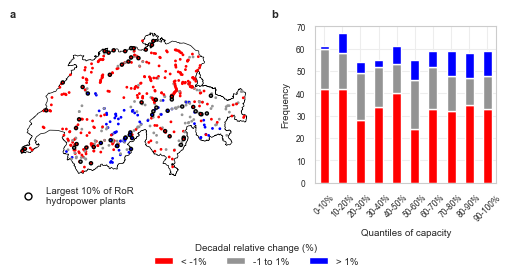

In [109]:
national_analysis.plot_winter_trend_map_and_distribution(variable_name="hp_no_beta_winter", save=True, output_filename="sup_fig_3.pdf")